<h1>Pharmaceutical Sales prediction across multiple stores</h1>

<h2>Overview</h2>

<h3>Business Need</h3>

*  You work at Rossmann Pharmaceuticals as a Machine Learning Engineer. The finance team wants to forecast sales in all their stores across several cities six weeks ahead of time. Managers in individual stores rely on their years of experience as well as their personal judgement to forecast sales. 

* The data team identified factors such as promotions, competition, school and state holidays, seasonality, and locality as necessary for predicting the sales across the various stores.
* Your job is to build and serve an end-to-end product that delivers this prediction to analysts in the finance team. 

<h3>Data fields</h3>

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended.
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [1]:
import os
import numpy as np
import pandas as pd

import logging
import warnings
warnings.filterwarnings("ignore")

# data visualization
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [2]:
def log (path,file):
    '''Creating a log file to record the project's logs'''
    #check if file exists
    log_file= os.path.join(path,file)

    if not os.path.isfile(log_file):
        open(log_file,"w+").close()

    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"

    #configure logger
    logging.basicConfig(level=logging.INFO,format=console_logging_format)
    logger=logging.getLogger()

    #file handler for output file
    handler=logging.FileHandler(log_file)

    #set logging level for file
    handler.setLevel(logging.INFO)

    #logging format
    formatter=logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)
    
    #add handlers to logger
    logger.addHandler(handler)

    return logger

In [3]:
'''path = 'data/train_store.csv'
repo = "../"
version = "'v2'"
# return to normal tag version and print in markdown

data_url = dvc.api.get_url(
    path=path,
    repo=repo,
)

mlflow.set_experiment('Rossmann Pharmeceutical Sales_Forecasting')

if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    df = pd.read_csv('../data/train_store.csv', index_col=0)
    mlflow.log_param('data_url', data_url)
    mlflow.log_param('data_version', version)
    mlflow.log_param('input_rows', df.shape[0])
    mlflow.log_param('input_cols', df.shape[1])'''

'path = \'data/train_store.csv\'\nrepo = "../"\nversion = "\'v2\'"\n# return to normal tag version and print in markdown\n\ndata_url = dvc.api.get_url(\n    path=path,\n    repo=repo,\n)\n\nmlflow.set_experiment(\'Rossmann Pharmeceutical Sales_Forecasting\')\n\nif __name__ == \'__main__\':\n    warnings.filterwarnings("ignore")\n    np.random.seed(40)\n    df = pd.read_csv(\'../data/train_store.csv\', index_col=0)\n    mlflow.log_param(\'data_url\', data_url)\n    mlflow.log_param(\'data_version\', version)\n    mlflow.log_param(\'input_rows\', df.shape[0])\n    mlflow.log_param(\'input_cols\', df.shape[1])'

In [4]:
#set logger file
logger = log(path="../logs/",file="rossman_sales.logs")

#Loading datasets
train_data = pd.read_csv("../files/train.csv",low_memory=False)
test_data = pd.read_csv("../files/test.csv",low_memory=False)
store = pd.read_csv("../files/store.csv",low_memory=False)

<h2>Data Cleaning and Wrangling</h2>

In [5]:
def get_info(data:pd.DataFrame):
    df = pd.DataFrame()
    df['columns'] = data.columns.to_list()
    df['null'] = data.isnull().sum().to_list()
    df['dtype'] = data.dtypes.to_list()
    print('Dataset shape:',data.shape)
    return df

<h3>Train dataset</h3>

In [6]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Questions to answer through EDA:
* What day of the week tends to have the highest sales/ customers?
* Are there stores that do better when there's a school holiday vs state holiday vs no holiday?
* Avg sales per customer
* What day/ week had the highest sales, was it a holiday?

In [7]:
get_info(train_data)

Dataset shape: (1017209, 9)


,columns,null,dtype
0,Store,0,int64
1,DayOfWeek,0,int64
2,Date,0,object
3,Sales,0,int64
4,Customers,0,int64
5,Open,0,int64
6,Promo,0,int64
7,StateHoliday,0,object
8,SchoolHoliday,0,int64


In [8]:
print(train_data.Open.value_counts())
print('-----------------------------------')
print('Number of unique stores:',train_data.Store.nunique())

Open
1    844392
0    172817
Name: count, dtype: int64
-----------------------------------
Number of unique stores: 1115


In [9]:
#sales when store is closed? 0=closed, 1=open
print('Sum of sales when store is closed?',train_data[train_data.Open == 0].Sales.sum())
#
print('number of rows where the sales were zero despite the stores being open',train_data[(train_data.Open == 1)&(train_data.Sales<1)].shape[0])

Sum of sales when store is closed? 0
number of rows where the sales were zero despite the stores being open 54


Feature Engineering

In [10]:
def extract_features(dataframe,is_train=False):
    df = dataframe.copy()
    #creating new features

    #date features
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    if is_train:
        df['Sales_per_Customer']=df['Sales']/df['Customers']
    else:
        df.drop('Id',axis=1,inplace=True)
        df.reset_index(drop=True,inplace=True)
    return df

In [11]:
#we only want information for open Stores since Stores can't make sales if they are closed

train = train_data[(train_data["Open"] == 1) ]#|(train_data['Sales'] != 0)] making no sales when store is open is information
#drop Open column since all the remaining data is when Stores are open
train.drop(['Open'],axis=1,inplace=True)
train.reset_index(drop=True, inplace=True)
train = extract_features(train,is_train=True)
train.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Sales_per_Customer
Date,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,0,1,31,7,2015,9.482883
2015-07-31,2,5,6064,625,1,0,1,31,7,2015,9.702400
2015-07-31,3,5,8314,821,1,0,1,31,7,2015,10.126675
2015-07-31,4,5,13995,1498,1,0,1,31,7,2015,9.342457
2015-07-31,5,5,4822,559,1,0,1,31,7,2015,8.626118


In [12]:
get_info(train)

Dataset shape: (844392, 11)


,columns,null,dtype
0,Store,0,int64
1,DayOfWeek,0,int64
2,Sales,0,int64
3,Customers,0,int64
4,Promo,0,int64
5,StateHoliday,0,object
6,SchoolHoliday,0,int64
7,Day,0,int32
8,Month,0,int32
9,Year,0,int32


In [13]:
print('Sales when Sales per customer is null',train[train.Sales_per_Customer.isnull()].Sales.unique())
print('Customers when Sales per customer is null',train[train.Sales_per_Customer.isnull()].Customers.unique())

Sales when Sales per customer is null [0]
Customers when Sales per customer is null [0]


In [14]:
train['Sales_per_Customer'].fillna(0,inplace=True)
#confirm there are no more null values
get_info(train)

Dataset shape: (844392, 11)


,columns,null,dtype
0,Store,0,int64
1,DayOfWeek,0,int64
2,Sales,0,int64
3,Customers,0,int64
4,Promo,0,int64
5,StateHoliday,0,object
6,SchoolHoliday,0,int64
7,Day,0,int32
8,Month,0,int32
9,Year,0,int32


In [15]:
train.to_csv('../clean_train.csv',index=True,compression='gzip')

In [16]:
c = train.select_dtypes(exclude='object').columns.tolist()
c.remove('Store')
c

['DayOfWeek',
 'Sales',
 'Customers',
 'Promo',
 'SchoolHoliday',
 'Day',
 'Month',
 'Year',
 'Sales_per_Customer']

<h3>Test dataset</h3>

In [17]:
get_info(test_data)

Dataset shape: (41088, 8)


,columns,null,dtype
0,Id,0,int64
1,Store,0,int64
2,DayOfWeek,0,int64
3,Date,0,object
4,Open,11,float64
5,Promo,0,int64
6,StateHoliday,0,object
7,SchoolHoliday,0,int64


In [18]:
#null values for Open
test_data[test_data.Open.isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [19]:
#all values are from the same store, 622
test_data[test_data.Store == 622].head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
3903,3904,622,7,2015-09-13,0.0,0,0,0


In [20]:
test_data[test_data.Store == 622].shape

(48, 8)

In [21]:
train_data[(train_data.Promo == 1)&(train_data.Open == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
1009916,512,1,2013-01-07,0,0,0,1,0,0
1009921,517,1,2013-01-07,0,0,0,1,0,1
1009964,560,1,2013-01-07,0,0,0,1,0,0
1010166,762,1,2013-01-07,0,0,0,1,0,0


Clearly we can have promos even when the store is closed, this doesn't help us fill na

We drop these rows

In [22]:
test_data.dropna(subset=['Open'],inplace=True)

#drop rows where the stores are not Open
test_data.drop('Open',axis=1,inplace=True)

In [23]:
test = extract_features(test_data)
#test.reset_index(drop=True,inplace=True)
test.sample()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
11214,130,5,1,0,1,4,9,2015


<h3>Store Dataset</h3>

* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [24]:
store.sample(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
696,697,d,a,3780.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
822,823,a,c,16210.0,11.0,2010.0,0,NaN,NaN,NaN


In [25]:
get_info(store)

Dataset shape: (1115, 10)


,columns,null,dtype
0,Store,0,int64
1,StoreType,0,object
2,Assortment,0,object
3,CompetitionDistance,3,float64
4,CompetitionOpenSinceMonth,354,float64
5,CompetitionOpenSinceYear,354,float64
6,Promo2,0,int64
7,Promo2SinceWeek,544,float64
8,Promo2SinceYear,544,float64
9,PromoInterval,544,object


In [26]:
store[store['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [27]:
fig = px.histogram(store['CompetitionDistance'])
fig.show()

In [28]:
print('mean',store['CompetitionDistance'].mean())
print('median',store['CompetitionDistance'].median())

mean 5404.901079136691
median 2325.0


In [29]:
#Fillna competition columns
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

The values are skewed to the right, and we have outliers as well, so we fill the null with the median 

To drop or not to drop CompetitionOpenSinceMonth, CompetitionOpenSinceYear columns?

* Is there a diff in model performance when we drop these columns?

In [30]:
'''competition_cols = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']
store[competition_cols] = store[competition_cols].fillna(store.mode().iloc[0])'''

"competition_cols = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']\nstore[competition_cols] = store[competition_cols].fillna(store.mode().iloc[0])"

We can use the KNN imputer to impute missing values for these 2 columns

In [31]:
store.Promo2.value_counts()

Promo2
1    571
0    544
Name: count, dtype: int64

In [32]:
store[(store['Promo2']==0) & (store['Promo2SinceWeek'].isnull()) & (store['Promo2SinceYear'].isnull()) & (store['PromoInterval'].isnull())].shape

(544, 10)

* The stores with Promo2SinceWeek, Promo2SinceYear and PromoInterval as null are the rows where Promo2 is = 0
* We fill Promo2SinceWeek and PromoSinceYear with 0 since they are of numerical type and PromoInterval with "No Promo"
* Fill CompetitionDistance with median and 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear' with mode

In [33]:
# Create an imputer with a strategy for categorical data
categorical_imputer = SimpleImputer(strategy='most_frequent')

batch_size = 100
store_imputed = store.copy()
# Calculate the number of batches
num_batches = len(store_imputed) // batch_size + 1
# Process data in batches

final_store = pd.DataFrame()
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size

    # Extract the current batch
    batch = store_imputed.iloc[start_idx:end_idx]
    batch['CompetitionOpenSinceMonth'] = categorical_imputer.fit_transform(batch[['CompetitionOpenSinceMonth']])
    batch['CompetitionOpenSinceYear'] = categorical_imputer.fit_transform(batch[['CompetitionOpenSinceYear']])
    final_store = pd.concat([final_store,batch])

print(final_store.shape)
final_store.tail()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,4.0,2012.0,0,NaN,NaN,NaN
1113,1114,a,c,870.0,4.0,2012.0,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,4.0,2012.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [34]:
#Fillna Promo columns
final_store['PromoInterval'].fillna("No Promo",inplace = True)
promo_cols = ['Promo2SinceWeek','Promo2SinceYear']
final_store[promo_cols] = final_store[promo_cols].fillna(0)
print('Are there any more null values? \n',final_store.isnull().any())

Are there any more null values? 
 Store                        False
StoreType                    False
Assortment                   False
CompetitionDistance          False
CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2                       False
Promo2SinceWeek              False
Promo2SinceYear              False
PromoInterval                False
dtype: bool


In [35]:
test_store = pd.merge(test, final_store, how = 'left', on = 'Store')
test_store.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,1,0,0,17,9,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
1,3,4,1,0,0,17,9,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,7,4,1,0,0,17,9,2015,a,c,24000.0,4.0,2013.0,0,0.0,0.0,No Promo
3,8,4,1,0,0,17,9,2015,a,a,7520.0,10.0,2014.0,0,0.0,0.0,No Promo
4,9,4,1,0,0,17,9,2015,a,c,2030.0,8.0,2000.0,0,0.0,0.0,No Promo


In [36]:
print(test.shape)
print(test_store.shape)

(41077, 8)
(41077, 17)


In [37]:
get_info(test_store)

Dataset shape: (41077, 17)


,columns,null,dtype
0,Store,0,int64
1,DayOfWeek,0,int64
2,Promo,0,int64
3,StateHoliday,0,object
4,SchoolHoliday,0,int64
5,Day,0,int32
6,Month,0,int32
7,Year,0,int32
8,StoreType,0,object
9,Assortment,0,object


In [38]:
test_store.T.apply(lambda x: x.nunique(),axis=1)

Store                        856
DayOfWeek                      7
Promo                          2
StateHoliday                   2
SchoolHoliday                  2
Day                           31
Month                          2
Year                           1
StoreType                      4
Assortment                     3
CompetitionDistance          555
CompetitionOpenSinceMonth     12
CompetitionOpenSinceYear      23
Promo2                         2
Promo2SinceWeek               22
Promo2SinceYear                8
PromoInterval                  4
dtype: int64

In [39]:
train_store = pd.merge(train, final_store, how = 'outer', on = 'Store')
train_store.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,0,1,31,7,2015,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
1,1,4,5020,546,1,0,1,30,7,2015,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
2,1,3,4782,523,1,0,1,29,7,2015,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
3,1,2,5011,560,1,0,1,28,7,2015,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
4,1,1,6102,612,1,0,1,27,7,2015,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo


In [40]:
get_info(train_store)

Dataset shape: (844392, 20)


,columns,null,dtype
0,Store,0,int64
1,DayOfWeek,0,int64
2,Sales,0,int64
3,Customers,0,int64
4,Promo,0,int64
5,StateHoliday,0,object
6,SchoolHoliday,0,int64
7,Day,0,int32
8,Month,0,int32
9,Year,0,int32


In [41]:
train_store.groupby(['StoreType'])['Store'].nunique()

StoreType
a    602
b     17
c    148
d    348
Name: Store, dtype: int64

In [42]:
train_store.T.apply(lambda x: x.nunique(),axis=1)

Store                          1115
DayOfWeek                         7
Sales                         21734
Customers                      4086
Promo                             2
StateHoliday                      4
SchoolHoliday                     2
Day                              31
Month                            12
Year                              3
Sales_per_Customer           651408
StoreType                         4
Assortment                        3
CompetitionDistance             655
CompetitionOpenSinceMonth        12
CompetitionOpenSinceYear         23
Promo2                            2
Promo2SinceWeek                  25
Promo2SinceYear                   8
PromoInterval                     4
dtype: int64

In [43]:
print('State Holiday',train_store.StateHoliday.unique())

State Holiday ['0' 'a' 'b' 'c']


In [44]:
print('State Holiday',test_store.StateHoliday.unique())

State Holiday ['0' 'a']


Make StateHoliday a binary column

In [45]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,0,1,31,7,2015,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
1,1,4,5020,546,1,0,1,30,7,2015,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
2,1,3,4782,523,1,0,1,29,7,2015,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
3,1,2,5011,560,1,0,1,28,7,2015,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
4,1,1,6102,612,1,0,1,27,7,2015,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo


In [46]:
train_store['StateHoliday'] = (train_store['StateHoliday']!='0').astype(int)
print(train_store.StateHoliday.unique())
train_store.head()

[0 1]


,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,0,1,31,7,2015,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
1,1,4,5020,546,1,0,1,30,7,2015,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
2,1,3,4782,523,1,0,1,29,7,2015,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
3,1,2,5011,560,1,0,1,28,7,2015,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
4,1,1,6102,612,1,0,1,27,7,2015,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo


In [47]:
#train_store.to_csv("../data/train_store.csv",index=False)

In [48]:
test_store.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,1,0,0,17,9,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
1,3,4,1,0,0,17,9,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,7,4,1,0,0,17,9,2015,a,c,24000.0,4.0,2013.0,0,0.0,0.0,No Promo
3,8,4,1,0,0,17,9,2015,a,a,7520.0,10.0,2014.0,0,0.0,0.0,No Promo
4,9,4,1,0,0,17,9,2015,a,c,2030.0,8.0,2000.0,0,0.0,0.0,No Promo


In [49]:
test_store['StateHoliday'] = (test_store['StateHoliday']!='0').astype(int)
print(test_store.StateHoliday.unique())
test_store.head()

[0 1]


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,1,0,0,17,9,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
1,3,4,1,0,0,17,9,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,7,4,1,0,0,17,9,2015,a,c,24000.0,4.0,2013.0,0,0.0,0.0,No Promo
3,8,4,1,0,0,17,9,2015,a,a,7520.0,10.0,2014.0,0,0.0,0.0,No Promo
4,9,4,1,0,0,17,9,2015,a,c,2030.0,8.0,2000.0,0,0.0,0.0,No Promo


In [50]:
test_store.to_csv('../data/test_store.csv',index=False)

<h2>Exploratory Data Analysis</h2>

In [51]:
def plot_stats(df,col):
    dataframe = df[[col]]

    dataframe = dataframe.resample('W').mean()
    fig = px.line(dataframe,title=f'Average monthly {col}',)
    fig.update_layout(
    xaxis_title='Date', yaxis_title=col,).update_traces(line_color='tomato')
    fig.show()

def plot_sales(data,col,x='Month',y='Sales',hue=None):
    if hue:
        sns.catplot(data=data,x=x,y=y,col=col,hue=hue,kind='point')
    else:
        sns.catplot(data,x=x,y=y,col=col,kind='point')
    plt.suptitle(f'{y} Comparison: {col} vs No {col}',y=1.02)
    plt.show()

In [52]:
#Factor plot
def plot_cat(data,x,y,col,hue):
    sns.catplot(data=data,x=x,y=y,col=col,hue=hue,kind='point')
    plt.show()
#Bar plot    
def plot_bar(data,x,y1,y2):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.barplot(data = data, x = x, y = y1,palette='RdYlBu') 
    plt.title(f'{x} VS {y1}')
    plt.subplot(1,2,2)
    sns.barplot(data = data, x = x, y = y2,palette='RdYlGn')
    plt.title(f'{x} VS {y2}')
    plt.show()
#Histogram
def plot_hist(data,col1,col2):
    sns.histplot(data=data,x=col1,y=col2,bins=30)
    plt.title(f'Distribution of {col1} by {col2}')
    plt.show()

In [53]:
plot_stats(train,'Sales')

In [54]:
plot_stats(train,'Customers')

* On average, sales and customers are lowest days before and after 31st Decemeber and highest a few weeks before Christmas
* Because most stores close on Christmas, a few days before the holiday, particularly from 16th December onwards, sales significantly increase and start dropping from 23rd 
* The lowest sales are observed around 31st December 

In [55]:
cols = train_store.select_dtypes(exclude='object').columns.tolist()
cols.remove('Store')
cols.remove('Sales_per_Customer')
fig = px.imshow(train_store[cols].corr(),color_continuous_scale='reds')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()

* Sales and Customers have a strong positive correlation of ~ 0.8
* Sales and Promo also have a positive correlation of ~0.4

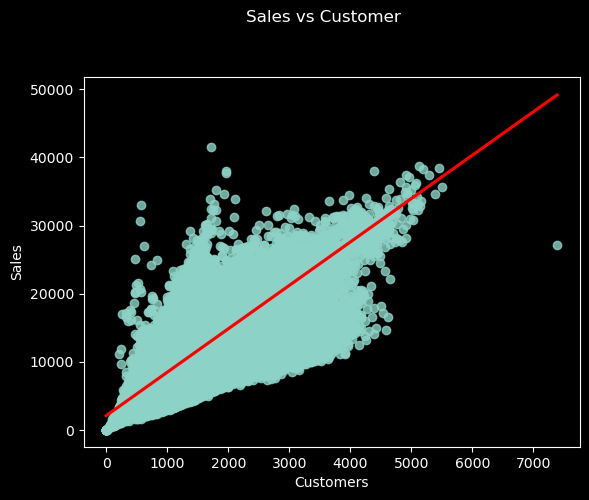

In [56]:
sns.regplot(train_store,x='Customers',y='Sales',line_kws=dict(color="r"),)
plt.suptitle('Sales vs Customer',y=1.02)
plt.show()

Because we're predicting sales, we will focus our EDA on this column

How do the following features affect sales?
* Promo
* School/ State holiday
* Day 
* Store Type
* Assortment

In [57]:
train_store.sample()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
237314,316,5,9003,860,0,0,0,11,4,2014,10.468605,d,a,9000.0,8.0,2001.0,0,0.0,0.0,No Promo


In [58]:
promo = train_store.groupby(['Month','Promo'])['Sales'].mean().reset_index()
months = promo.Month.unique().tolist()
#promo.set_index('Month',inplace=True)
promo

,Month,Promo,Sales
0,1,0,5591.904236
1,1,1,7782.800277
2,2,0,5747.812834
3,2,1,7772.909263
4,3,0,5805.723545
5,3,1,8252.983345
6,4,0,5855.305439
7,4,1,8426.029528
8,5,0,6300.749699
9,5,1,8087.946860


In [59]:
import calendar
months = list(calendar.month_name)
months = months[1:]
months

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [60]:
fig = px.line(promo,x='Month',y='Sales',facet_col='Promo',markers=True,)
fig.update_traces(line_color='red')
fig.update_xaxes(tickvals=promo['Month'])
fig.update_layout(
    yaxis_title = 'Sales',showlegend=False
)
fig.show()

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


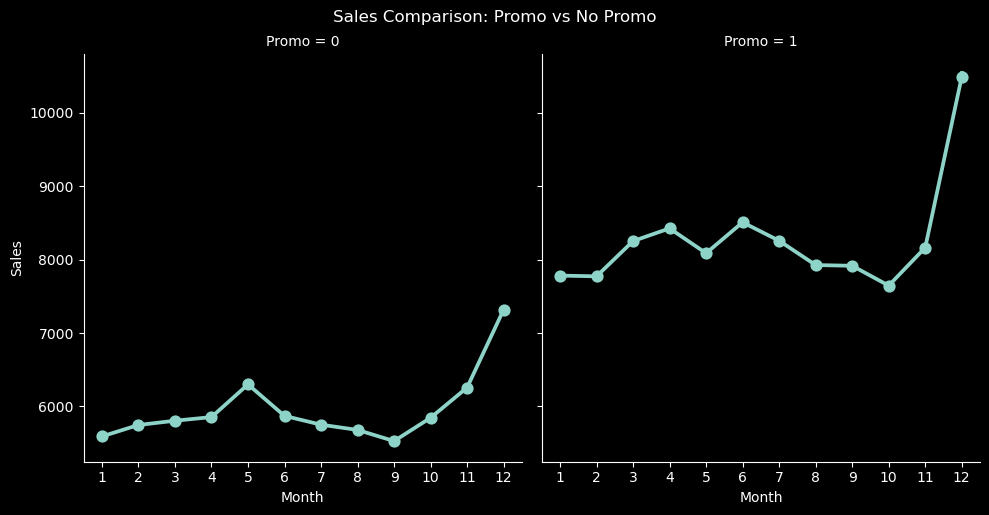

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


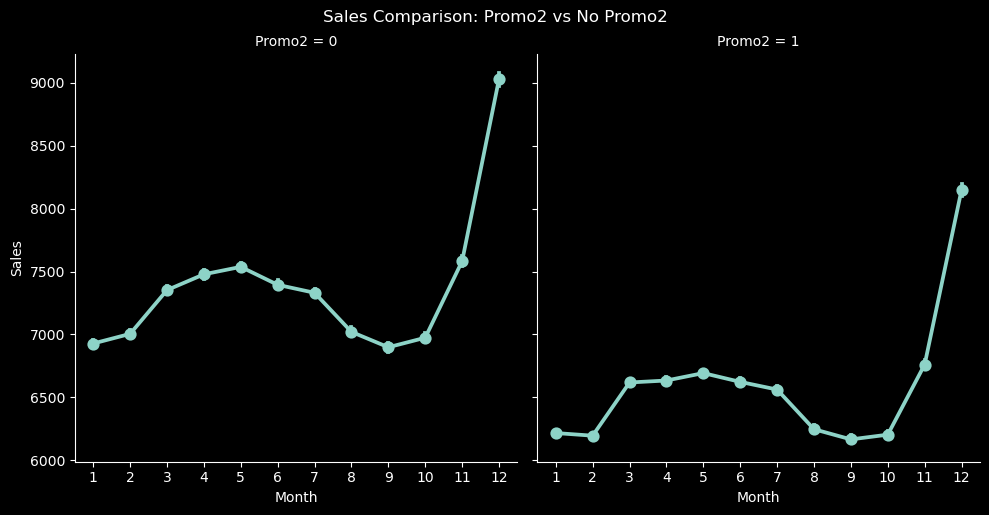

In [61]:
plot_sales(train_store,'Promo')
plot_sales(train_store,'Promo2')

* There are higher sales when stores have a Promo
* Stores that are participating in Promo2 seem to have LESS SALES, than those not participating.
But maybe this is because fewer stores are paricipating in promo2? Nope

In [62]:
train_store.groupby('Promo2').agg({'Store':'nunique','Sales':'sum'})

,Store,Sales
Promo2,,
0,544,3111542628
1,571,2761637995


In [63]:
#In fact, we have more stores participating in Promo2 yet they have lower Sales <br>
#Can you participate in both Promo and Promo2?

print('Stores participating in Promo:',train_store[(train_store.Promo==1)].Store.nunique())
print('Stores participating in Promo2:',train_store[(train_store.Promo2==1)].Store.nunique())
print('Stores participating in both Promo and Promo2:',train_store[(train_store.Promo==1)&(train_store.Promo2==1)].Store.nunique())

Stores participating in Promo: 1115
Stores participating in Promo2: 571
Stores participating in both Promo and Promo2: 571


What StoreTypes and Assortment tend to have higher sales?

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


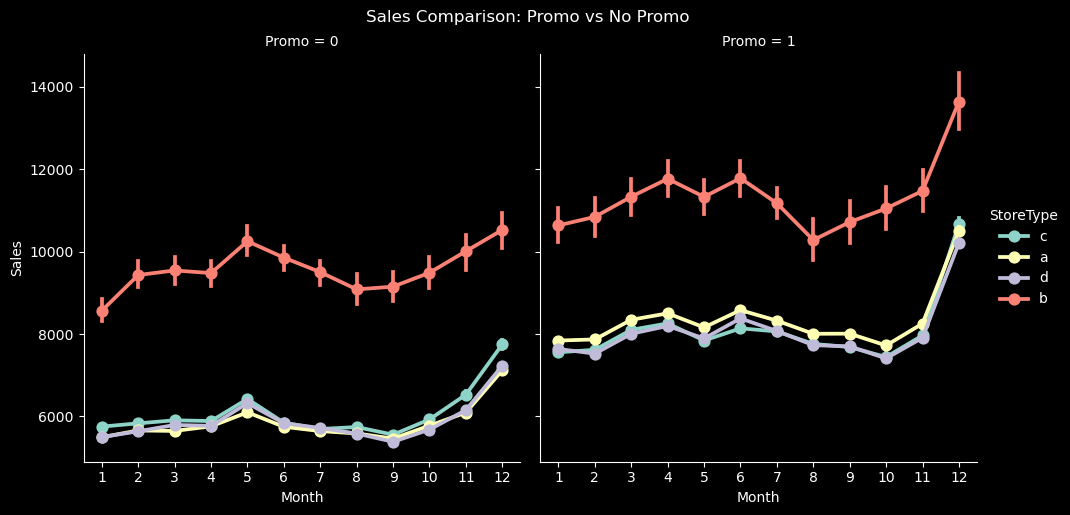

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


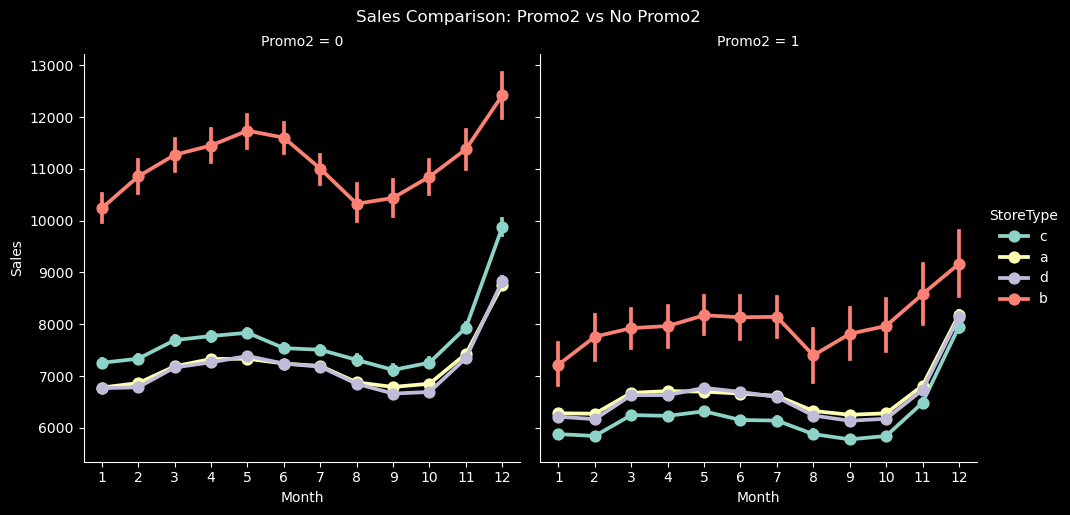

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


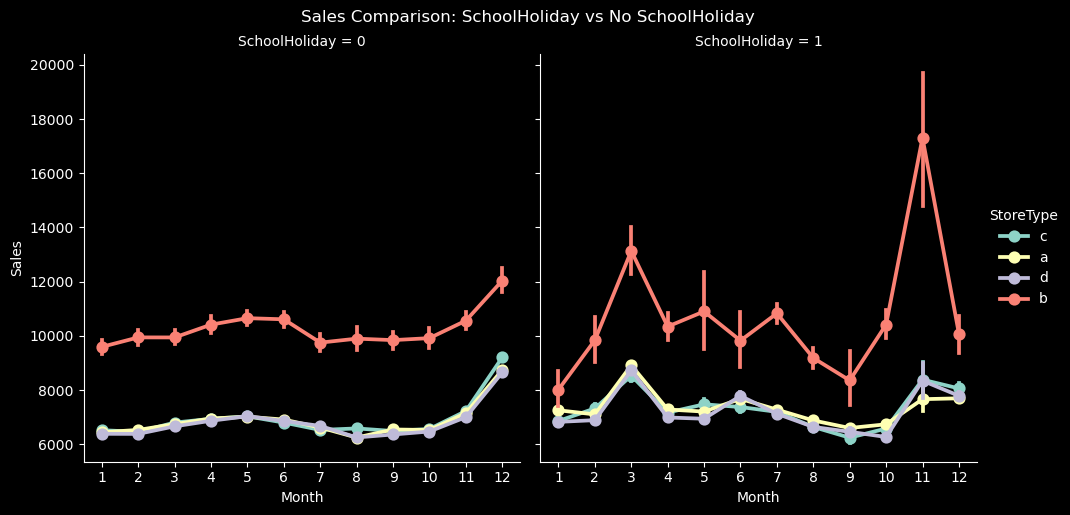

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


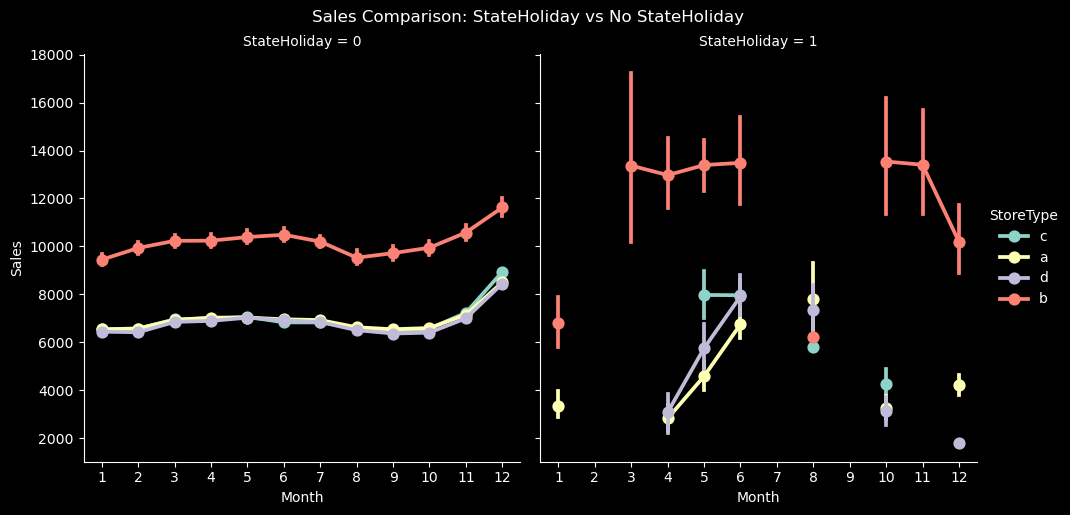

In [64]:
plot_sales(train_store,'Promo',hue='StoreType')
plot_sales(train_store,'Promo2',hue='StoreType')
plot_sales(train_store,'SchoolHoliday',hue='StoreType') 
plot_sales(train_store,'StateHoliday',hue='StoreType') 

In [65]:
#Are more stores categorised under 'b' or what's the reason behind the significantly higher sales?
train_store.groupby(['StoreType']).agg({'Store':['nunique','count'],'Sales':['sum','mean'],'Customers':'sum'})

Store               Sales                Customers
          nunique   count         sum          mean        sum
StoreType                                                     
a             602  457077  3165334859   6925.167661  363541434
b              17   15563   159231395  10231.407505   31465621
c             148  112978   783221426   6932.512755   92129705
d             348  258774  1765392943   6822.141881  156904995

* StoreType b has the lowest number of stores but highest average sales. Stores under this category could possible sell low priced, frequently bought items
* However, we can see that promotions lead to higher sales and customers for all store types

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


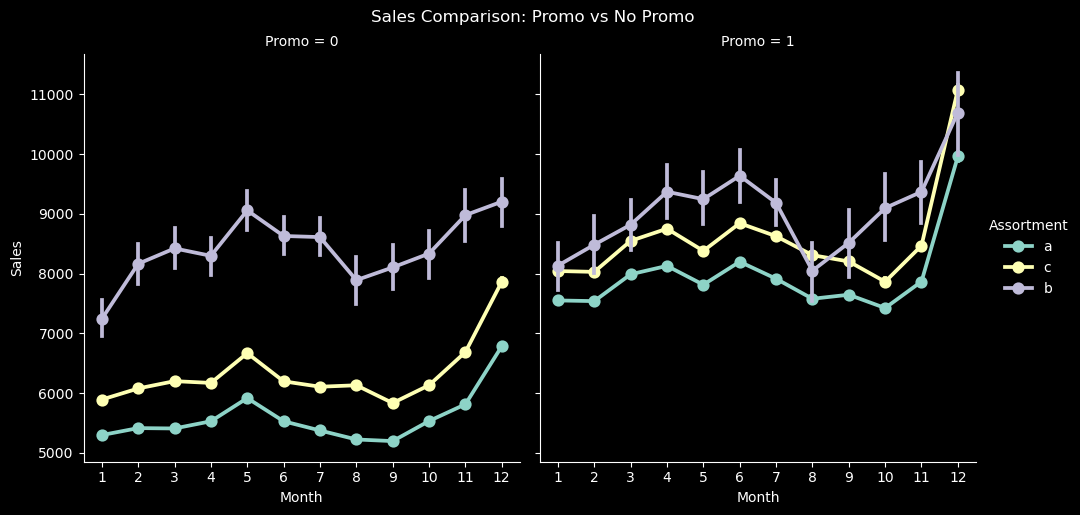

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


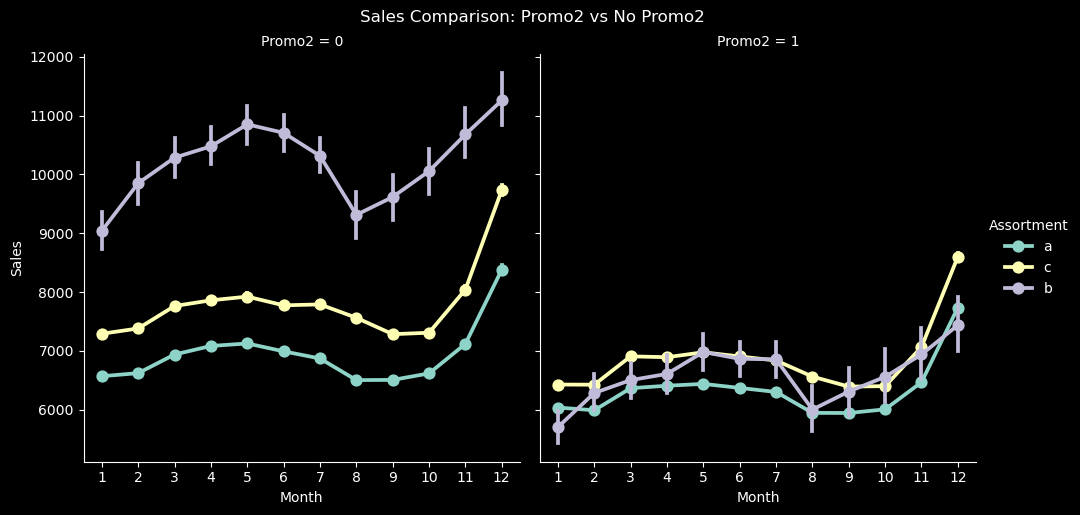

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


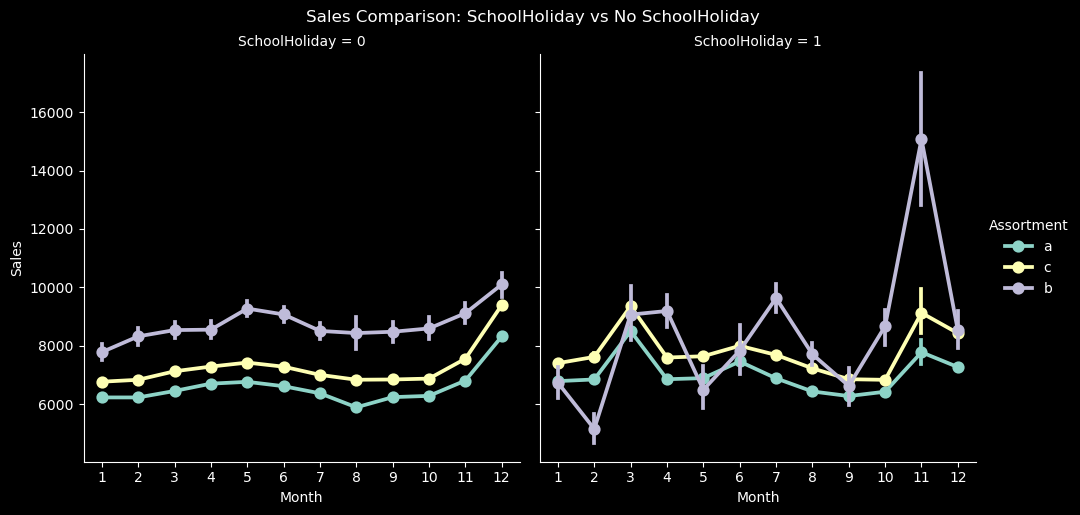

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


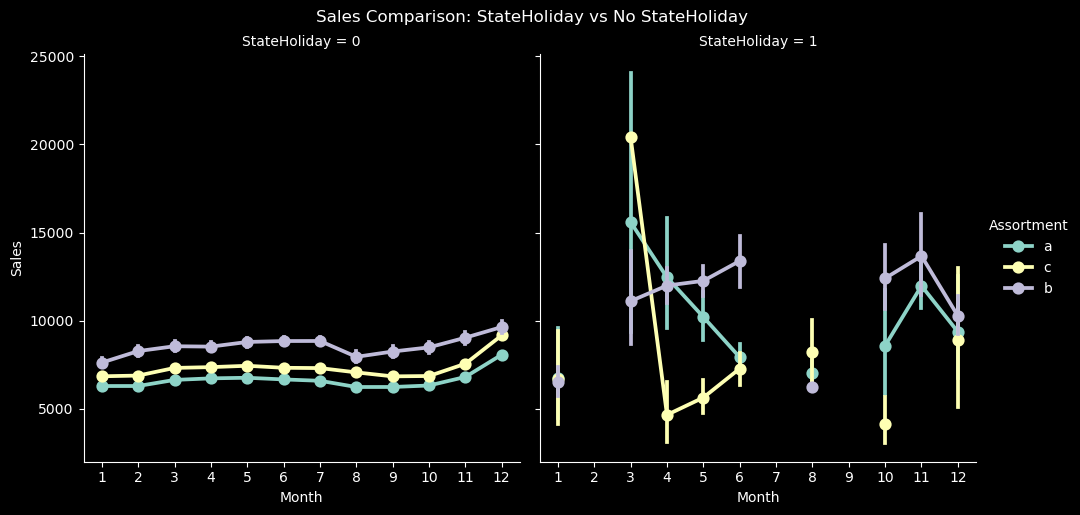

In [66]:
plot_sales(train_store,'Promo',hue='Assortment')
plot_sales(train_store,'Promo2',hue='Assortment')
plot_sales(train_store,'SchoolHoliday',hue='Assortment') 
plot_sales(train_store,'StateHoliday',hue='Assortment') 

In [67]:
train_store.groupby(['Assortment']).agg({'Store':['nunique','count'],'Sales':['sum','mean'],'Customers':'sum'})

Store               Sales               Customers
           nunique   count         sum         mean        sum
Assortment                                                    
a              593  444909  2945750070  6621.017039  332766938
b                9    8212    70946312  8639.346322   16972525
c              513  391271  2856484241  7300.526339  294302292

In [68]:
train_store.groupby(['Assortment','StoreType']).agg({'Store':['nunique','count'],'Sales':['sum','mean'],'Customers':'sum'})

Store               Sales                Customers
                     nunique   count         sum          mean        sum
Assortment StoreType                                                     
a          a             381  286053  1870105131   6537.617613  217184233
           b               7    6409    71357761  11133.992979   11568136
           c              77   58561   400260421   6834.931456   49183207
           d             128   93886   604026757   6433.619038   54831362
b          b               9    8212    70946312   8639.346322   16972525
c          a             221  171024  1295229728   7573.379923  146357201
           b               1     942    16927322  17969.556263    2924960
           c              71   54417   382961005   7037.525130   42946498
           d             220  164888  1161366186   7043.363895  102073633

Assortment b only has StoreType b

**Could the promos be deployed in more effective ways? Which stores should promos be deployed in?**

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


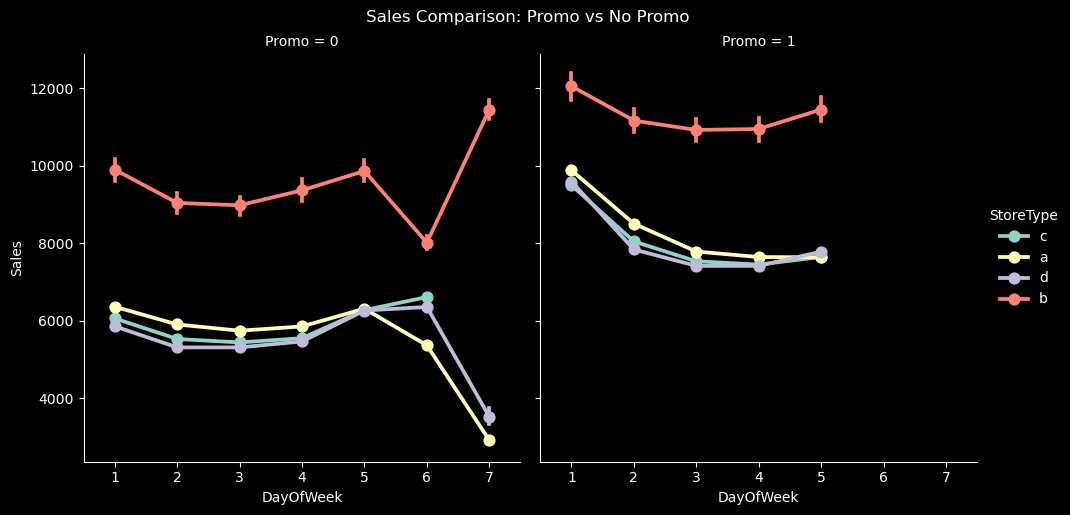

In [69]:
plot_sales(train_store,'Promo',x='DayOfWeek',hue='StoreType',) 

In [70]:
#For StoreType a,c,d sales are highest on Mondays Fridays and Saturdays and lowest on Sundays. 
#Are these stores not open on Sundays?

print('Average Sales for StoreType a,c,d on Sunday:',train_store[(train_store.Promo == 0)&(train_store.DayOfWeek == 7) & (train_store.StoreType != 'b')].Sales.mean())
print('Average Sales for StoreType a,c,d on other days:',train_store[(train_store.Promo == 0)&(train_store.DayOfWeek != 7) & (train_store.StoreType != 'b')].Sales.mean())
print('-----------------------------------------------------------')
print('Average Sales for StoreType b on Sunday:',train_store[(train_store.Promo == 0)&(train_store.DayOfWeek == 7) & (train_store.StoreType == 'b')].Sales.mean())
print('Average Sales for StoreType b on other days:',train_store[(train_store.Promo == 0)&(train_store.DayOfWeek != 7) & (train_store.StoreType == 'b')].Sales.mean())

Average Sales for StoreType a,c,d on Sunday: 3034.4473493100945
Average Sales for StoreType a,c,d on other days: 5861.462078528618
-----------------------------------------------------------
Average Sales for StoreType b on Sunday: 11449.909296028882
Average Sales for StoreType b on other days: 9003.498177399757


In [71]:
#promos not done on weekends?
train_store[(train_store.Promo==1)&((train_store.DayOfWeek==6)| (train_store.DayOfWeek==7))]

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


* Promos are not done on Sundays 
* Without Promos, Store Type b has the most sales on Sundays,

**Check how the assortment type affects sales**

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


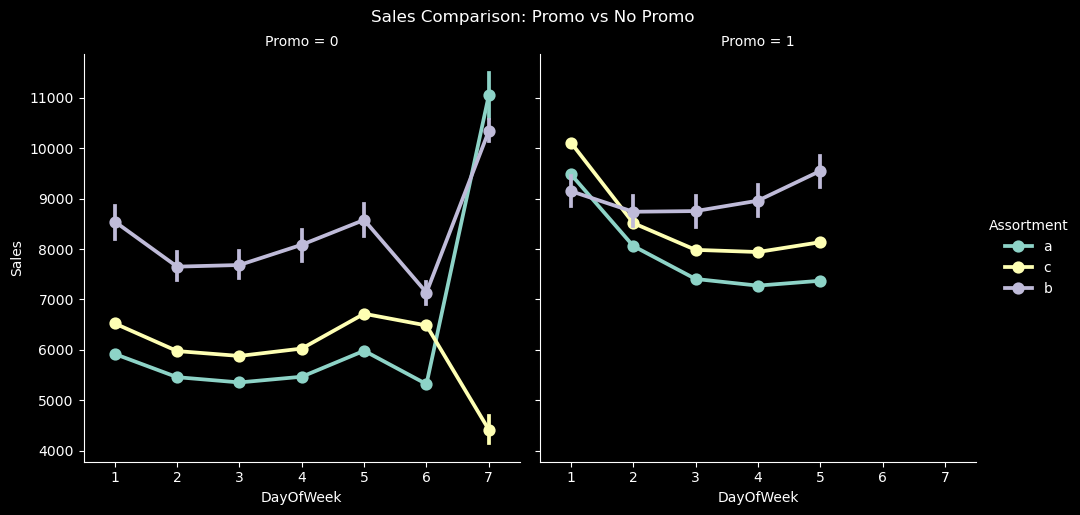

In [72]:
plot_sales(train_store,'Promo',x='DayOfWeek',hue='Assortment',) 

In [73]:
train_store.groupby(['Assortment','Promo']).agg({'Store':['nunique','count'],'Sales':['sum','mean'],'Customers':'sum'})

Store               Sales               Customers
                 nunique   count         sum         mean        sum
Assortment Promo                                                    
a          0         593  245989  1367628813  5559.715325  165947922
           1         593  198920  1578121257  7933.446898  166819016
b          0           9    5078    42646059  8398.199882   10212393
           1           9    3134    28300253  9030.074346    6760132
c          0         513  216429  1361699465  6291.668238  149617492
           1         513  174842  1494784776  8549.346130  144684800

* Assortment b has the highest average sale, with and without a promo
* Assortment c overall has higher sales than a, but really low sales on Sundays when compared to b and a
* Promos lead to higher sales for all Assortment types 

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


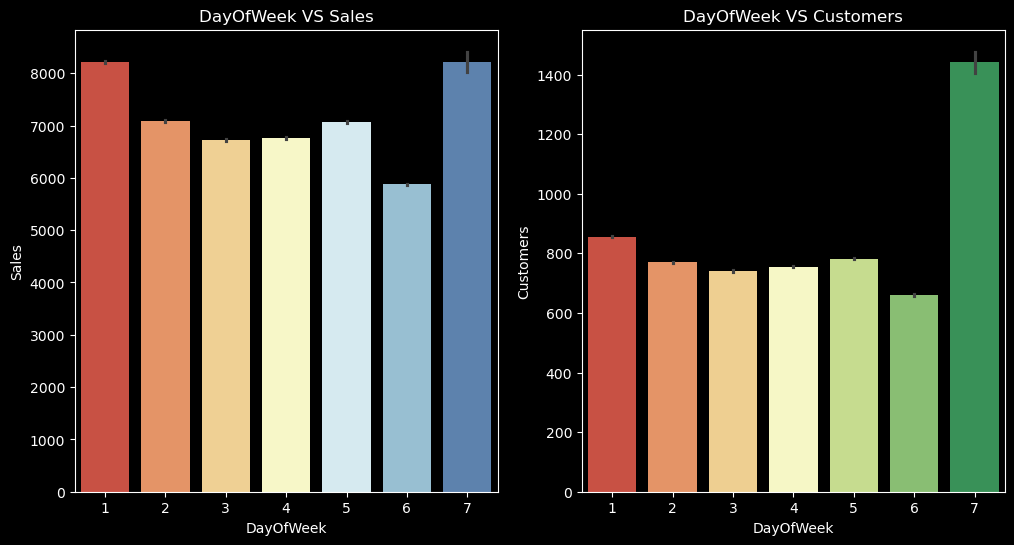

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


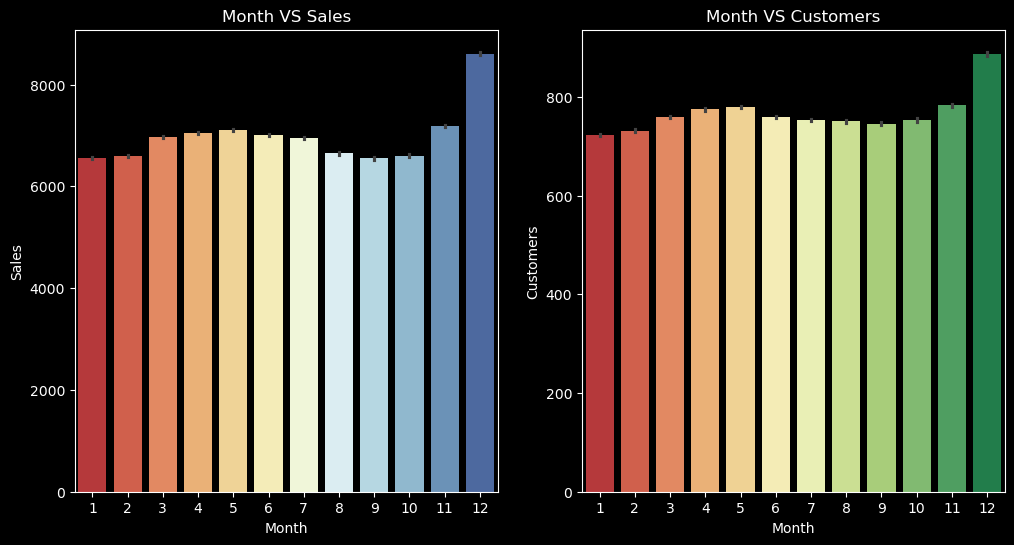

In [74]:
plot_bar(train_store,'DayOfWeek','Sales','Customers')
plot_bar(train_store,'Month','Sales','Customers')

* Mondays and Sundays have the most sales and customers
* Sundays have the most customers

**How does the distance to the next competitor affect sales?**

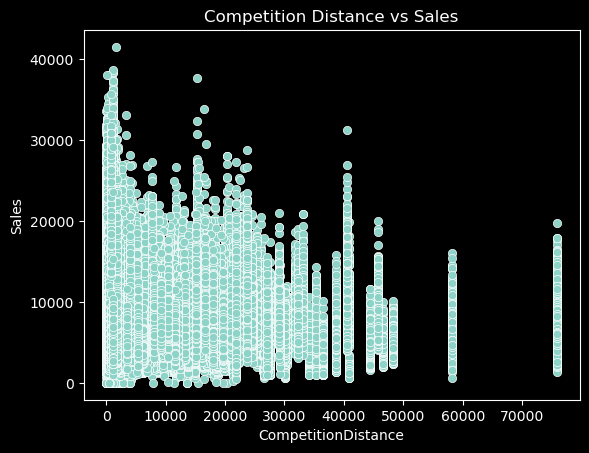

In [75]:
sns.scatterplot(train_store,x='CompetitionDistance',y='Sales')
plt.title('Competition Distance vs Sales')
plt.show()

No linear trend between Competition Distance and Sales
But we can observe the highest sales when CompetitionDistance is small

In [76]:
import plotly.figure_factory as ff
import numpy as np
np.random.seed(1)

x = np.random.randn(1000)
hist_data = [x]
group_labels = ['distplot'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

In [77]:
[x]

[array([ 1.62434536e+00, -6.11756414e-01, -5.28171752e-01, -1.07296862e+00,
         8.65407629e-01, -2.30153870e+00,  1.74481176e+00, -7.61206901e-01,
         3.19039096e-01, -2.49370375e-01,  1.46210794e+00, -2.06014071e+00,
        -3.22417204e-01, -3.84054355e-01,  1.13376944e+00, -1.09989127e+00,
        -1.72428208e-01, -8.77858418e-01,  4.22137467e-02,  5.82815214e-01,
        -1.10061918e+00,  1.14472371e+00,  9.01590721e-01,  5.02494339e-01,
         9.00855949e-01, -6.83727859e-01, -1.22890226e-01, -9.35769434e-01,
        -2.67888080e-01,  5.30355467e-01, -6.91660752e-01, -3.96753527e-01,
        -6.87172700e-01, -8.45205641e-01, -6.71246131e-01, -1.26645989e-02,
        -1.11731035e+00,  2.34415698e-01,  1.65980218e+00,  7.42044161e-01,
        -1.91835552e-01, -8.87628964e-01, -7.47158294e-01,  1.69245460e+00,
         5.08077548e-02, -6.36995647e-01,  1.90915485e-01,  2.10025514e+00,
         1.20158952e-01,  6.17203110e-01,  3.00170320e-01, -3.52249846e-01,
        -1.1

In [78]:
hist_data = [train_store['CompetitionDistance'].values]
hist_data

[array([1270., 1270., 1270., ..., 1100., 1100., 1100.])]

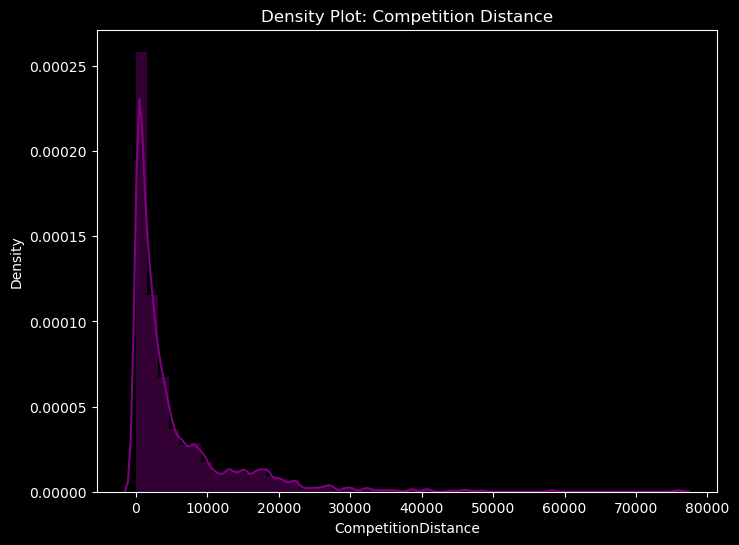

In [79]:
#CompetitionDistance
fig = plt.figure(figsize = (8,6))
sns.distplot(train_store.CompetitionDistance, color = 'purple')
plt.title('Density Plot: Competition Distance')
plt.show()

* The stores could be located in densely populated areas hence, distance to nearest competitor has a small influence on Sales
* Most stores are located around 5km from competitors

In [80]:
train_store.sample()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
50745,68,6,9111,1221,0,0,0,18,4,2015,7.461916,a,c,250.0,10.0,2014.0,1,35.0,2012.0,"Mar,Jun,Sept,Dec"


CompetitionOpenSinceMonth,CompetitionOpenSinceYear

In [81]:
comp = train_store[train_store.CompetitionOpenSinceMonth.notnull()].reset_index(drop=True)
comp.sample()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
508284,673,3,5559,520,1,0,0,10,4,2013,10.690385,d,c,15170.0,4.0,2012.0,1,5.0,2013.0,"Feb,May,Aug,Nov"


INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


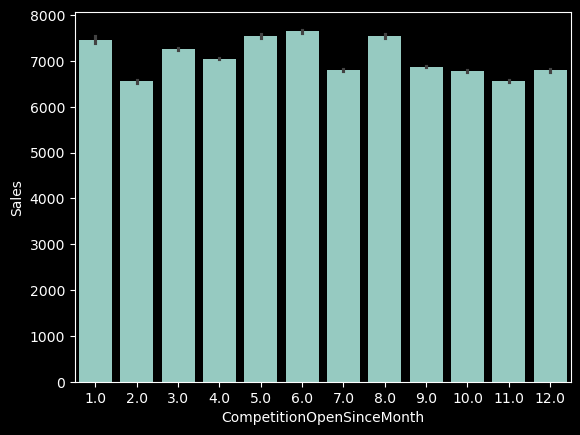

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


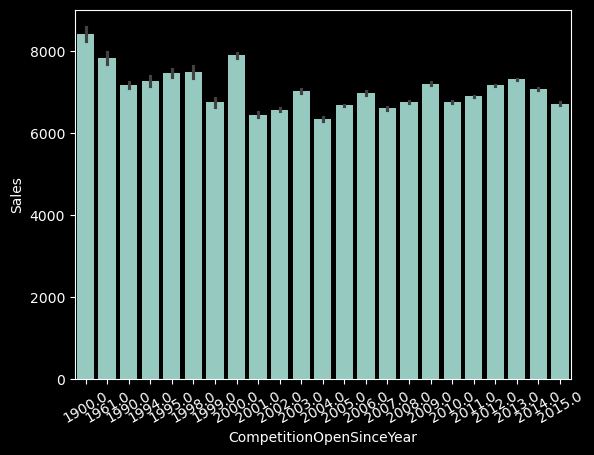

In [82]:
sns.barplot(comp,x='CompetitionOpenSinceMonth',y='Sales')
plt.show()
sns.barplot(comp,x='CompetitionOpenSinceYear',y='Sales')
plt.xticks(rotation=30)
plt.show()

<h2>Machine Learning </h2>
<h3>Feature Selection</h3>

* Ordinal Variable: Finite variable set of discrete values with a ranked ordering between the values. This include:
    * PromoSinceYear,CompetitionOpenSinceYear, Decile_rank(already ranked), Year -> Label encoding
* Nominal Variable: Finite variable set of discrete values with no relationship between values. 
    * Day Of Week, Month, StateHoliday, StoreType, Assortment, CompetitionOpenSinceMonth. PromoSinceWeek, PromoInterval,Day Month -> One hot encoding for features like StateHoliday,StoreType,Assortment and Frequency encoding for the rest

In [83]:
train_store.T.apply(lambda x: x.nunique(),axis=1)

Store                          1115
DayOfWeek                         7
Sales                         21734
Customers                      4086
Promo                             2
StateHoliday                      2
SchoolHoliday                     2
Day                              31
Month                            12
Year                              3
Sales_per_Customer           651408
StoreType                         4
Assortment                        3
CompetitionDistance             655
CompetitionOpenSinceMonth        12
CompetitionOpenSinceYear         23
Promo2                            2
Promo2SinceWeek                  25
Promo2SinceYear                   8
PromoInterval                     4
dtype: int64

In [84]:
train_store.StateHoliday.unique()

array([0, 1])

In [85]:
train_store.sample()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
376010,497,5,10141,1320,1,0,0,22,3,2013,7.682576,a,c,1610.0,9.0,2005.0,0,0.0,0.0,No Promo


In [86]:
train_store.SchoolHoliday.unique()

array([1, 0], dtype=int64)

In [87]:
def transform_features(data,sales_present=True):
    ml_cols = test_store.columns.tolist()
    ml_cols.remove('Store')
    df = data[ml_cols]
    #label encoding ordinal columns
    le = LabelEncoder()
    ord_columns = ['Promo2SinceYear','CompetitionOpenSinceYear','Year']

    ord_df = pd.DataFrame()
    for i in ord_columns:
        ord_df[i] = le.fit_transform(df[i].astype(str))

    #one hot encode nominal columns with few unique variables
    one_cols = ['StateHoliday','StoreType','Assortment','PromoInterval']
    dummies = pd.get_dummies(df[one_cols])

    #list of numerical columns
    num_cols = ['CompetitionDistance']
    #standardise numerical columns
    min_max = MinMaxScaler()

    num_df = df.loc[:,num_cols]
    num_df[num_cols] = min_max.fit_transform(num_df[num_cols])

    other_cols = [col for col in df.columns if col not in ord_columns if col not in one_cols if col not in num_cols]
    other_df = df[other_cols]
    transform_df = pd.concat([other_df.reset_index(drop=True),num_df.reset_index(drop=True),ord_df.reset_index(drop=True),
                      dummies.reset_index(drop=True)],axis=1,ignore_index=True)

    transform_cols = [list(other_cols),list(num_df.columns),list(ord_df.columns),list(dummies.columns)]

    flatten = lambda nested_lists: [item for sublist in nested_lists for item in sublist]

    transform_df.columns = flatten(transform_cols)
    if sales_present:
        sales = data.Sales.values
        return transform_df,sales
    else: 
        return transform_df
    

In [88]:
#shuffle entire dataset
clean_df = train_store[:300000]
clean_df.to_csv('../train_store.csv',index=False,compression='gzip')
clean_df = train_store.sample(frac=1,random_state=42)

train,val,test = np.split(clean_df,[int(len(train_store)*0.6),int(len(train_store)*0.8)])
train.shape

(506635, 20)

In [89]:
X_train,y_train = transform_features(train)
X_test,y_test = transform_features(test)
X_val,y_val = transform_features(val)

In [90]:
X_train.sample()

,DayOfWeek,Promo,SchoolHoliday,Day,Month,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,CompetitionDistance,Promo2SinceYear,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_No Promo
370004,4,1,0,11,4,7.0,0,0.0,0.025448,0,...,False,False,False,True,False,False,False,False,False,True


In [91]:
X_train.columns

Index(['DayOfWeek', 'Promo', 'SchoolHoliday', 'Day', 'Month',
       'CompetitionOpenSinceMonth', 'Promo2', 'Promo2SinceWeek',
       'CompetitionDistance', 'Promo2SinceYear', 'CompetitionOpenSinceYear',
       'Year', 'StateHoliday', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec', 'PromoInterval_No Promo'],
      dtype='object')

In [92]:
rand = RandomForestRegressor(random_state=37)
rand.fit(X_train,y_train)
rand_pred = rand.predict(X_val)

In [93]:
dtree = DecisionTreeRegressor(splitter='random', max_depth=10, random_state=2)
dtree.fit(X_train,y_train)
dtree_pred = dtree.predict(X_val)

In [94]:
sgd = SGDRegressor(eta0=0.1,fit_intercept=False,shuffle=False,learning_rate='adaptive',random_state=2)
sgd.fit(X_train,y_train)
sgd_pred = sgd.predict(X_val)

In [95]:
def loss_function(actual,pred):
    rmse=np.sqrt(mean_squared_error(actual,pred))
    mae=mean_absolute_error(actual,pred)
    r_squared = r2_score(actual,pred)
    print('RMSE:',rmse)
    print('MAE',mae)
    print('R squared',r_squared)
    

In [96]:
#loss function
def rmse_function(actual,pred):
    rmse=np.sqrt(mean_squared_error(actual,pred))
    return rmse
def mae_function(actual,pred):
    mae=mean_absolute_error(actual,pred)
    return mae

In [97]:
loss_function(y_val,rand_pred)

RMSE: 980.2718994110295
MAE 620.5118657255532
R squared 0.8990809591764032


In [98]:
loss_function(y_val,dtree_pred)

RMSE: 2462.0091298622538
MAE 1768.8716017485722
R squared 0.36341071291393134


In [99]:
loss_function(y_val,sgd_pred)

RMSE: 2731.678854693433
MAE 2000.9007281321133
R squared 0.21631905094270143


In [100]:
'''mlflow.log_metric('RandomForest_RMSE',rmse_function(y_val,rand_pred))
mlflow.log_metric('RandomForest_MAE',mae_function(y_val,rand_pred))

mlflow.log_metric('DecisionTree_RMSE',rmse_function(y_val,dtree_pred))
mlflow.log_metric('DecisionTree_MAE',mae_function(y_val,dtree_pred))

mlflow.log_metric('SGDRegression_RMSE',rmse_function(y_val,sgd_pred))
mlflow.log_metric('SGDRegression_MAE',mae_function(y_val,sgd_pred))'''

"mlflow.log_metric('RandomForest_RMSE',rmse_function(y_val,rand_pred))\nmlflow.log_metric('RandomForest_MAE',mae_function(y_val,rand_pred))\n\nmlflow.log_metric('DecisionTree_RMSE',rmse_function(y_val,dtree_pred))\nmlflow.log_metric('DecisionTree_MAE',mae_function(y_val,dtree_pred))\n\nmlflow.log_metric('SGDRegression_RMSE',rmse_function(y_val,sgd_pred))\nmlflow.log_metric('SGDRegression_MAE',mae_function(y_val,sgd_pred))"

The Random Forest model has an R squared value of ~ 0.899 meaning that 89.9% of the variability in Sales is explained by the features in the model. 

An RMSE score of 980 means that on average the models predictions differ from the actual Sales values by about 1141 sales

In [101]:
feature_names = X_train.columns.tolist()
importance = dtree.feature_importances_
features_df = pd.DataFrame({'Features':feature_names,'Importance':importance})
features_df.sort_values(by='Importance',ascending=False,inplace=True)
features_df

,Features,Importance
1,Promo,0.360621
0,DayOfWeek,0.102676
8,CompetitionDistance,0.067748
14,StoreType_b,0.066080
5,CompetitionOpenSinceMonth,0.055830
10,CompetitionOpenSinceYear,0.053740
9,Promo2SinceYear,0.042325
4,Month,0.037822
17,Assortment_a,0.037736
19,Assortment_c,0.030033


In [102]:
[t for t in train_store if t not in test_store]

['Sales', 'Customers', 'Sales_per_Customer']

In [103]:
def plot_feature_importance(train_x,model):
    feature_names = train_x.columns.tolist()
    importance = model.feature_importances_
    features_df = pd.DataFrame({'Features':feature_names,'Importance':importance})
    features_df.sort_values(by='Importance',ascending=False,inplace=True)
    fig = px.bar(features_df,x='Importance',y='Features',title=f'{model} Feature Importance')
    return fig

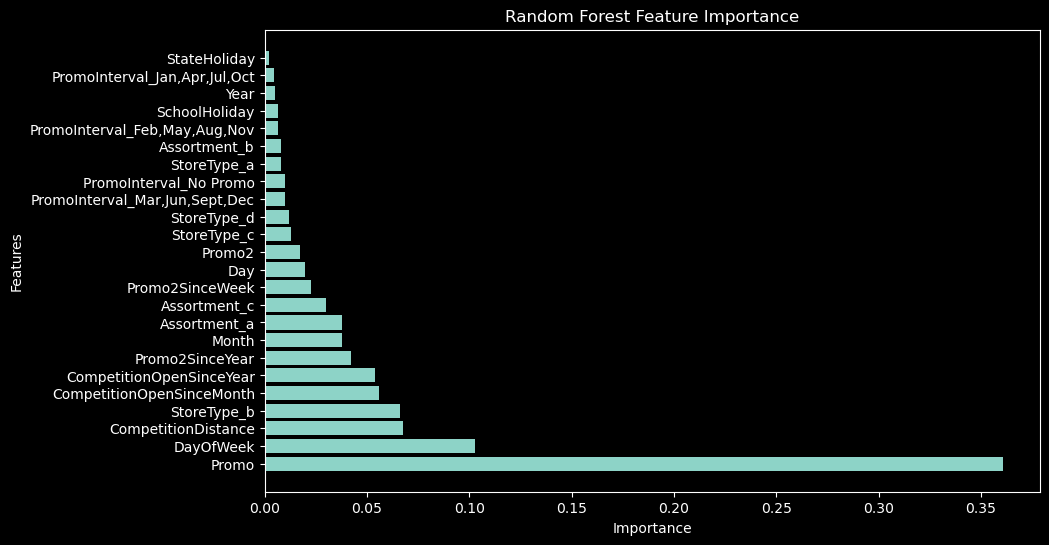

In [104]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(features_df['Features'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

In [105]:
#How well does the random forest generalise to unseen data? Did it overfit?
preds = rand.predict(X_test)
loss_function(y_test,preds)

RMSE: 980.157837643433
MAE 619.654603236637
R squared 0.901149131843028


The R squared is even higher with the test set

In [106]:
test_store.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,1,0,0,17,9,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,No Promo
1,3,4,1,0,0,17,9,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,7,4,1,0,0,17,9,2015,a,c,24000.0,4.0,2013.0,0,0.0,0.0,No Promo
3,8,4,1,0,0,17,9,2015,a,a,7520.0,10.0,2014.0,0,0.0,0.0,No Promo
4,9,4,1,0,0,17,9,2015,a,c,2030.0,8.0,2000.0,0,0.0,0.0,No Promo


In [107]:
X_test_store = transform_features(test_store,sales_present=False)
X_test_store.head()

,DayOfWeek,Promo,SchoolHoliday,Day,Month,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,CompetitionDistance,Promo2SinceYear,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_No Promo
0,4,1,0,17,9,9.0,0,0.0,0.016482,0,...,False,True,False,True,False,False,False,False,False,True
1,4,1,0,17,9,12.0,1,14.0,0.186050,3,...,False,False,False,True,False,False,False,True,False,False
2,4,1,0,17,9,4.0,0,0.0,0.316192,0,...,False,False,False,False,False,True,False,False,False,True
3,4,1,0,17,9,10.0,0,0.0,0.098892,0,...,False,False,False,True,False,False,False,False,False,True
4,4,1,0,17,9,8.0,0,0.0,0.026503,0,...,False,False,False,False,False,True,False,False,False,True


In [108]:
rand.predict(X_test_store)

array([ 4711.56,  8137.64,  9523.79, ...,  6114.15, 21929.29,  6187.96])